# Speed Dating Data
https://www.kaggle.com/annavictoria/speed-dating-experiment

# 3 Feature Engineering/Pre-processing & Modeling (ver. keep chosen categorical columns), both female and male decisions


## 3.1  Imports

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
from scipy import stats

from sb_utils import save_file

In [4]:
# not sure if I need this
import datetime
import unicodedata
import re
from sklearn.preprocessing import scale

## 3.2 Objectives

In the data wrangling notebook, we have identified our target dependent variable as desicion of parner of the specific subject, dec_o (might also consider match, desicion from both the subject and the partner) and cleaned the data accordingly. In this notebook, we will conduct further EDA, hoping to answer following questions.

1. The difference of desirable attributes in a male partner vs female partner.
2. The difference of desirable attributes among  races.
3. The difference of desirable major of male partner vs female partner
4. The difference of desirable majors among races.  

**Learning Objectives**:
Preprocessing:
1. Understand the importance of creating a model training development data set.
2. Correctly identify when to create dummy features or one-hot encoded features.
3. Understand the importance of magnitude standardization.
4. Apply the train and test split to the development dataset effectively

Modeling:
1. Fit your models with a training dataset 
    - Use cross-validation for hyperparameter tuning
2. Review model outcomes — Iterate over additional models as needed
    - Caclulate accuracy, recall, precision, and F1.
3. Identify the final model that you think is the best model for this project
    - Most power model interms of model evaluation metrics, computational complexity, scalability, and maintenance costs.

Here is possible workflow: TBD
1. Pre-processing:
    - Removed columns with categorical meaning before fillna with mean
    - Got dummy variables for all the columns with categorical meaning and with missing data
        - Converted the type int/float to object beforehand.
        - Make sure to use pd.get_dummies(df, drop_first=False), without dropping rows with missing values. Leave the first column so that missing value information is not lost.  Missing value can be considered as a category label as its own.
        - Removed the original categorical columns with missing data
    - Split into training/test set > fill NaN with mean, scale within training set and test set separately
        - Extract columns with numeric meaning to scale
        - Removed dummy variables columns and binary columns before scaling the numeric columns
        - Combined the dummy variable columns, binary columns and scaled numeric columns per train set and test set.
    - perform PCA on scaled numeric columns to reduce dimension
        - Keep enough pca components to explain ~90% var. 
        - Combined the dummy variable columns, binary columns and pca columns from scaled numeric columns
2. Modeling:
    - logistic regression model via sklearn and statsmodel
        - Use GridSearchCV (cv=5) for feature engineering
        - Use stepwise selection, elastic-net (or L1/L2 regularizers) if possible
    - Random Forest model via sklearn
    - Compare all models using confusion matrix and classification report
3. Feature importance analysis
    - Use SHAP for sklearn model
    - in order to answer feature importance for Male and Female, ran the model with male data and female data separately (done).
    - in ordr to answer feature importance for different races, can run the model with each race seprately (not done)

## 3.3 Load The Data

In [5]:
# df = pd.read_csv('../data/ski_data_cleaned.csv')
spd = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_cleaned.csv') #spd1_2 in data wrangling notebook
spd_fp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_FemaleRatingMale_cleaned.csv') # spd1_2fp in data wrangling notebook 
spd_mp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_MaleRatingFemale_cleaned.csv') # spd1_2mp in data wrangling notebook

In [6]:
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.14,0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.54,0,...,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.16,1,...,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.61,0,...,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.21,0,...,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0


In [7]:
spd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    6266 non-null   int64  
 1   match     6266 non-null   int64  
 2   age       6198 non-null   float64
 3   race      6208 non-null   float64
 4   field     6208 non-null   object 
 5   career    6182 non-null   object 
 6   from      6192 non-null   object 
 7   goal      6192 non-null   float64
 8   int_corr  6118 non-null   float64
 9   samerace  6266 non-null   int64  
 10  imprace   6192 non-null   float64
 11  imprelig  6192 non-null   float64
 12  age_o     6189 non-null   float64
 13  race_o    6198 non-null   float64
 14  dec_o     6266 non-null   int64  
 15  attr_o    6127 non-null   float64
 16  sinc_o    6064 non-null   float64
 17  intel_o   6054 non-null   float64
 18  fun_o     5999 non-null   float64
 19  amb_o     5709 non-null   float64
 20  shar_o    5399 non-null   floa

In [8]:
# check for NaN
spd.isna().sum() 
# need to remove cotegorical feature with type int or float before fill NaN with mean
# remove: race, goal, race_o, met_o > leave put to be dealt with dummy variables

gender        0
match         0
age          68
race         58
field        58
career       84
from         74
goal         74
int_corr    148
samerace      0
imprace      74
imprelig     74
age_o        77
race_o       68
dec_o         0
attr_o      139
sinc_o      202
intel_o     212
fun_o       267
amb_o       557
shar_o      867
like_o      162
prob_o      212
met_o       269
dtype: int64

In [9]:
# check for column value range
spd.describe()

,gender,match,age,race,goal,int_corr,samerace,imprace,imprelig,age_o,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
count,6266.000000,6266.000000,6198.000000,6208.000000,6192.000000,6118.000000,6266.000000,6192.000000,6192.000000,6189.000000,...,6266.000000,6127.000000,6064.000000,6054.000000,5999.000000,5709.000000,5399.000000,6104.000000,6054.000000,5997.000000
mean,0.500798,0.170763,26.257180,2.691205,2.152616,0.192596,0.405043,3.804748,3.734981,26.265148,...,0.427705,6.233132,7.223615,7.403204,6.418736,6.826152,5.554269,6.166317,5.233812,1.956145
std,0.500039,0.376332,3.525651,1.219243,1.430158,0.303994,0.490940,2.882531,2.814576,3.521609,...,0.494785,1.934149,1.717217,1.528342,1.952552,1.770204,2.141403,1.850402,2.142853,0.263864
min,0.000000,0.000000,18.000000,1.000000,1.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,24.000000,2.000000,1.000000,-0.017500,0.000000,1.000000,1.000000,24.000000,...,0.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,5.000000,4.000000,2.000000
50%,1.000000,0.000000,26.000000,2.000000,2.000000,0.210000,0.000000,3.000000,3.000000,26.000000,...,0.000000,6.000000,7.000000,8.000000,7.000000,7.000000,6.000000,6.000000,5.000000,2.000000
75%,1.000000,0.000000,28.000000,4.000000,2.000000,0.430000,1.000000,6.000000,6.000000,28.000000,...,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,2.000000
max,1.000000,1.000000,42.000000,6.000000,6.000000,0.900000,1.000000,10.000000,10.000000,42.000000,...,1.000000,10.500000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000,8.000000


In [10]:
# met_o supposed to be binary (1 or 2) column but it was not. double check its unique value
spd.met_o.unique() # people might have mistakenly input how many times have met before?

array([ 2.,  1., nan,  3.,  5.,  6.,  7.,  8.])

In [11]:
# check the value of categorical columns we want to get dummy variables
spd.race.unique()

array([ 4.,  2.,  6.,  3.,  1., nan])

In [12]:
spd.race_o.unique()

array([ 2.,  4.,  3.,  6.,  1., nan])

In [13]:
spd.field.unique() # too much but want to keep it for now

array(['Law', 'law', 'Economics', 'Masters in Public Administration',
       'Masters of Social Work&Education', 'Finance', 'Business',
       'political science', 'money', 'Operations Research',
       'TC (Health Ed)', 'Psychology', 'social work', 'Social Work',
       'Speech Language Pathology', 'Speech Languahe Pathology',
       'Educational Psychology', 'Applied Maths/Econs', 'Mathematics',
       'Statistics', 'Organizational Psychology',
       'Mechanical Engineering', 'Finanace', 'Finance&Economics',
       'Undergrad - GS', 'Mathematical Finance', 'Medicine', 'MBA', 'LAW',
       nan, 'psychology', 'German Literature',
       'Business & International Affairs', 'MFA Creative Writing',
       'Engineering', 'Electrical Engineering', 'Classics',
       'Operations Research (SEAS)', 'chemistry', 'Journalism',
       'Elementary/Childhood Education (MA)', 'microbiology',
       'Masters of Social Work', 'Communications', 'Marketing',
       'Chemistry', 'International Education

In [14]:
spd['from'].unique() # spd.from.unique() didn't work, too much options > drop b/c less interested

array(['Chicago', 'Alabama', 'Connecticut', 'Texas', 'Bowdoin College',
       'MD', 'Southern California', 'London, England',
       'Palm Springs, California', '94115', 'Argentina', 'England',
       'Cincinnati, Ohio', 'Miami', 'Milan - Italy', 'Georgia, USA',
       'New York', 'california', 'Washington DC', 'New Jersey',
       'Ann Arbor, MI', 'Hong Kong', 'new york', 'Iowa', 'California',
       'Westchester, NY', nan, 'Washington, DC', 'Boston', 'new jersey',
       'Michigan', 'SIngapore', 'Brazil', 'Brandeis University',
       'Cincinnati, OH', 'Los Angeles', 'SF Bay Area, CA', 'China',
       'San Francisco(home)/Los Angeles(undergrad)', 'Spain', 'Israel',
       'Switzerland', 'Italy', 'Philadelphia', 'Houston', 'Brooklyn',
       'Florida', 'Tuscaloosa, Alabama', 'Albuquerque, NM',
       'Palo Alto, California', 'Boston, MA', 'Mexico', 'Torrance, CA',
       'St. Louis, MO', 'London, UK', 'Minnesota', 'Ohio',
       'India/Venezuela', 'Washington State', 'Panama', 'spain

In [15]:
spd.career.unique() # too much options... this is 'intended' career > drop will keep filed instead 
# if want to include this, can reduce the option by merging similar ones.

array(['lawyer', 'law', 'Economist', 'lawyer/policy work', 'Law',
       'Journalist', 'Congresswoman, and comedian',
       'To create early childhood intervention programs',
       'Academia, Research, Banking, Life', 'Corporate Lawyer', 'Lawyer',
       'Corporate attorney', 'research/financial industry',
       'academics or journalism', 'Financial Services', 'ceo', 'CEO',
       'Undecided', 'Informatics', 'psychologist',
       'health/nutrition oriented social worker', 'Social Worker',
       'Social work with children', 'Speech Language Pathologist', nan,
       'Social Work Administration', 'Professor', "Clidren's TV",
       'Banking', 'Capital Markets', 'Biostatistics',
       'Organizational Change Consultant', 'tech professional',
       'Engineer', 'Academic', 'academia', 'banker / academia', 'banker',
       'Music production', 'Entrepreneur',
       'Intellectual Property Attorney', 'Medicine', 'consulting',
       'LAWYER', 'social worker', 'comedienne', 'attorney',
  

In [16]:
spd.goal.unique() # goal for attending this speed dating, not many options so will keep

array([ 2.,  1.,  6.,  3.,  4., nan,  5.])

## 3.4 Pre-processing data

### 3.4.1 Get dummy variables of chosen categorical columns

In [17]:
# exctract categorical data
# refer to '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk'
# dfo = df.select_dtypes(include='object')
# spd1 = spd[['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o']]  
#%%%%% converting all this features to variables took forever to run the ML model
spd1 = spd[['race', 'field', 'goal', 'race_o', 'met_o']]  # dropped less interested features
# did not include 'gender' and 'match' columns b/c they are binary column w/o missing data
spd1.head()

,race,field,goal,race_o,met_o
0,4.0,Law,2.0,2.0,2.0
1,4.0,Law,2.0,2.0,2.0
2,4.0,Law,2.0,4.0,1.0
3,4.0,Law,2.0,2.0,2.0
4,4.0,Law,2.0,3.0,2.0


In [18]:
# check column type
spd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    6208 non-null   float64
 1   field   6208 non-null   object 
 2   goal    6192 non-null   float64
 3   race_o  6198 non-null   float64
 4   met_o   5997 non-null   float64
dtypes: float64(4), object(1)
memory usage: 244.9+ KB


In [19]:
# convert to object type 
spd1_o = spd1.astype('object') #%%%%% get_dummies did not work on int/float type
spd1_o.head()

,race,field,goal,race_o,met_o
0,4,Law,2,2,2
1,4,Law,2,2,2
2,4,Law,2,4,1
3,4,Law,2,2,2
4,4,Law,2,3,2


In [20]:
# check column type
spd1_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    6208 non-null   object
 1   field   6208 non-null   object
 2   goal    6192 non-null   object
 3   race_o  6198 non-null   object
 4   met_o   5997 non-null   object
dtypes: object(5)
memory usage: 244.9+ KB


In [21]:
# get dummy variable from the exctracted categorical data
# refer to 14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
spd1_odm = pd.get_dummies(spd1_o) # since spd1_o categorial type features still have many missing data, kept drop_first=False
spd1_odm.head() # pd.get_dummies() automatically removed the orignal categorical variables

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [22]:
# check for NaN
spd1_odm.isna().sum()

race_1.0     0
race_2.0     0
race_3.0     0
race_4.0     0
race_6.0     0
            ..
met_o_3.0    0
met_o_5.0    0
met_o_6.0    0
met_o_7.0    0
met_o_8.0    0
Length: 222, dtype: int64

In [23]:
spd1_odm.shape

(6266, 222)

In [24]:
# extract the numeric data
spd2 = spd.drop(columns=['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o'])
spd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    6266 non-null   int64  
 1   match     6266 non-null   int64  
 2   age       6198 non-null   float64
 3   int_corr  6118 non-null   float64
 4   samerace  6266 non-null   int64  
 5   imprace   6192 non-null   float64
 6   imprelig  6192 non-null   float64
 7   age_o     6189 non-null   float64
 8   dec_o     6266 non-null   int64  
 9   attr_o    6127 non-null   float64
 10  sinc_o    6064 non-null   float64
 11  intel_o   6054 non-null   float64
 12  fun_o     5999 non-null   float64
 13  amb_o     5709 non-null   float64
 14  shar_o    5399 non-null   float64
 15  like_o    6104 non-null   float64
 16  prob_o    6054 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 832.3 KB


In [25]:
# add these dummy variables back to the numeric data
# make sure to remove the original categorical data with missing data: field, career, from, 'race', 'goal', 'race_o', 'met_o'
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
spd_odm = pd.merge(spd1_odm, spd2, left_index=True, right_index=True)
print(spd_odm.shape)
spd_odm.head()

(6266, 239)


,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,age_o,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,27.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,22.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,22.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,23.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,24.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [26]:
# check NaN
spd_odm.isna().sum() 

race_1.0      0
race_2.0      0
race_3.0      0
race_4.0      0
race_6.0      0
           ... 
fun_o       267
amb_o       557
shar_o      867
like_o      162
prob_o      212
Length: 239, dtype: int64

### 3.4.2 Set up/Split input data (X and y) into test set and train set

In [27]:
# spd_odm
X = spd_odm.drop(columns='dec_o')
y = spd_odm['dec_o']

In [28]:
# check
X.shape, y.shape

((6266, 238), (6266,))

In [29]:
X.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,4.0,27.0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,4.0,23.0,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,4.0,24.0,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [30]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: dec_o, dtype: int64

In [31]:
# Split the data into a training and test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
5462,0,1,0,0,0,0,0,0,0,0,...,2.0,30.0,9.0,9.0,9.0,9.0,9.0,6.0,7.0,5.0
4842,0,1,0,0,0,0,0,0,0,0,...,2.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4993,0,0,0,1,0,0,0,0,0,0,...,1.0,29.0,6.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0
1024,0,1,0,0,0,0,0,0,0,0,...,7.0,28.0,6.0,6.0,8.0,8.0,7.0,3.0,7.0,6.0
2960,0,1,0,0,0,0,0,0,0,0,...,8.0,25.0,5.0,8.0,7.0,9.0,8.0,5.0,6.0,5.0


In [33]:
X_test.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
5607,0,1,0,0,0,0,0,0,0,0,...,2.0,29.0,5.0,8.0,7.0,7.0,NaN,8.0,7.0,7.0
2302,0,0,0,1,0,0,0,0,0,0,...,1.0,31.0,5.0,6.0,9.0,6.0,9.0,3.0,8.0,5.0
4672,0,0,0,0,0,0,0,0,0,0,...,NaN,34.0,10.0,9.0,7.0,8.0,8.0,7.0,8.0,8.5
3831,0,1,0,0,0,0,0,0,0,0,...,2.0,34.0,4.0,7.0,7.0,7.0,7.0,8.0,6.0,4.0
6005,0,0,0,1,0,0,0,0,0,0,...,8.0,30.0,7.0,7.0,8.0,4.0,9.0,3.0,3.0,3.0


In [34]:
# reset index
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
X_train = X_train.reset_index(drop=True)
X_train.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,2.0,30.0,9.0,9.0,9.0,9.0,9.0,6.0,7.0,5.0
1,0,1,0,0,0,0,0,0,0,0,...,2.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,1,0,0,0,0,0,0,...,1.0,29.0,6.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0
3,0,1,0,0,0,0,0,0,0,0,...,7.0,28.0,6.0,6.0,8.0,8.0,7.0,3.0,7.0,6.0
4,0,1,0,0,0,0,0,0,0,0,...,8.0,25.0,5.0,8.0,7.0,9.0,8.0,5.0,6.0,5.0


In [35]:
X_test = X_test.reset_index(drop=True)
X_test.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,2.0,29.0,5.0,8.0,7.0,7.0,NaN,8.0,7.0,7.0
1,0,0,0,1,0,0,0,0,0,0,...,1.0,31.0,5.0,6.0,9.0,6.0,9.0,3.0,8.0,5.0
2,0,0,0,0,0,0,0,0,0,0,...,NaN,34.0,10.0,9.0,7.0,8.0,8.0,7.0,8.0,8.5
3,0,1,0,0,0,0,0,0,0,0,...,2.0,34.0,4.0,7.0,7.0,7.0,7.0,8.0,6.0,4.0
4,0,0,0,1,0,0,0,0,0,0,...,8.0,30.0,7.0,7.0,8.0,4.0,9.0,3.0,3.0,3.0


In [36]:
#%%%% should rest_index for statsmodel input to avoid 'ValueError: The indices for endog and exog are not aligned'
#%%%% make sure to 'drop=True' to keep y as 1d array (2d array etc will cause error as input for sklearn).
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
y_train.shape, y_test.shape

((5012,), (1254,))

In [37]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
5007    0
5008    1
5009    1
5010    0
5011    0
Name: dec_o, Length: 5012, dtype: int64

### 3.4.3 Filling NaN of numeric data with mean

In [38]:
y.isna().sum() # no need to clean 

0

In [39]:
# extract categorial data & binary data without missing data
X_train1 = X_train.loc[:, 'race_1.0':'match']
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Columns: 224 entries, race_1.0 to match
dtypes: int64(2), uint8(222)
memory usage: 1.1 MB


In [40]:
X_test1 = X_test.loc[:, 'race_1.0':'match']
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Columns: 224 entries, race_1.0 to match
dtypes: int64(2), uint8(222)
memory usage: 291.6 KB


In [41]:
# check for NaN
X_train1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [42]:
X_test1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [43]:
# extract the numeric data with missing data
X_train2 = X_train.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4952 non-null   float64
 1   int_corr  4894 non-null   float64
 2   samerace  5012 non-null   int64  
 3   imprace   4951 non-null   float64
 4   imprelig  4951 non-null   float64
 5   age_o     4953 non-null   float64
 6   attr_o    4893 non-null   float64
 7   sinc_o    4844 non-null   float64
 8   intel_o   4834 non-null   float64
 9   fun_o     4794 non-null   float64
 10  amb_o     4552 non-null   float64
 11  shar_o    4319 non-null   float64
 12  like_o    4878 non-null   float64
 13  prob_o    4835 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 548.3 KB


In [44]:
X_test2 = X_test.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1246 non-null   float64
 1   int_corr  1224 non-null   float64
 2   samerace  1254 non-null   int64  
 3   imprace   1241 non-null   float64
 4   imprelig  1241 non-null   float64
 5   age_o     1236 non-null   float64
 6   attr_o    1234 non-null   float64
 7   sinc_o    1220 non-null   float64
 8   intel_o   1220 non-null   float64
 9   fun_o     1205 non-null   float64
 10  amb_o     1157 non-null   float64
 11  shar_o    1080 non-null   float64
 12  like_o    1226 non-null   float64
 13  prob_o    1219 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 137.3 KB


In [45]:
# fill mean within train set
X_train2_mean = X_train2.fillna(X_train2.mean())
# check for NaN
X_train2_mean.isna().sum(), X_train2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (5012, 14))

In [46]:
# fill mean within test set
X_test2_mean = X_test2.fillna(X_test2.mean())
# check for NaN
X_test2_mean.isna().sum(), X_test2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (1254, 14))

### 3.4.4 Scale continuous numeric features (leaving out the target, binary, and categorical features)

In [47]:
# check range
X_train2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000
mean,26.280089,0.189221,0.407821,3.784084,3.738437,26.265899,6.248518,7.230801,7.392118,6.414372,6.824253,5.574786,6.173534,5.232575
std,3.490230,0.303591,0.491479,2.858123,2.817267,3.478382,1.901186,1.682903,1.505726,1.911513,1.682632,1.998645,1.832262,2.108025
min,18.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.020000,0.000000,1.000000,1.000000,24.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.190000,0.000000,3.000000,3.000000,26.000000,6.000000,7.000000,7.392118,6.414372,7.000000,5.574786,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,6.000000,28.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [48]:
X_test2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,26.166132,0.206087,0.393939,3.887188,3.721193,26.262136,6.172123,7.195082,7.447131,6.436100,6.833621,5.472222,6.137602,5.238720
std,3.570587,0.286929,0.488817,2.894281,2.720196,3.586027,1.957020,1.715050,1.488139,1.907075,1.718224,1.942339,1.802826,2.100152
min,18.000000,-0.570000,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,23.000000,0.010000,0.000000,1.000000,1.000000,24.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.210000,0.000000,3.000000,3.000000,26.000000,6.000000,7.000000,7.447131,7.000000,7.000000,5.472222,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,6.000000,28.000000,7.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.500000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000


In [49]:
# drop samerace, binary feature without missing data
X_train3_mean = X_train2_mean.drop(columns='samerace')
X_test3_mean = X_test2_mean.drop(columns='samerace')

In [50]:
# refer to '6_GuidedCapstone/04_preprocessing_and_training_mk'
# refer to '16.3.1_Capstone_Two_Step_4__Preprocessing_Training_Data_Development.pdf'
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk.ipynb'
from sklearn.preprocessing import StandardScaler
# Making a Scaler object based on train set and apply it to test set to scale the test set
scaler = StandardScaler().fit(X_train3_mean)

# apply the scaler to train set
X_train_mean_scaled = scaler.transform(X_train3_mean)
print(type(X_train_mean_scaled))
X_train_mean_scaled = pd.DataFrame(X_train_mean_scaled, columns=X_train3_mean.columns)
X_train_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-0.366800,1.517912,0.425467,-0.617126,1.073624,1.447389,1.051383e+00,1.067952,1.352795,1.293190e+00,2.127725e-01,4.511080e-01,-1.103394e-01
1,-0.653343,0.134334,2.175042,-0.617126,-0.363970,0.000000,5.278184e-16,0.000000,0.000000,5.279032e-16,4.444347e-16,4.847925e-16,4.213741e-16
2,-0.939885,-0.425686,-0.974193,-0.972116,0.786105,-0.130731,4.571124e-01,0.403754,0.306399,1.044580e-01,1.213550e+00,4.511080e-01,8.385108e-01
3,2.212084,1.122604,0.425467,1.157820,0.498586,-0.130731,-7.314289e-01,0.403754,0.829597,1.044580e-01,-1.288394e+00,4.511080e-01,3.640857e-01
4,-0.939885,-0.623340,0.775382,1.512810,-0.363970,-0.656770,4.571124e-01,-0.260444,1.352795,6.988242e-01,-2.876165e-01,-9.471982e-02,-1.103394e-01


In [51]:
# apply the scaler to test set
X_test_mean_scaled = scaler.transform(X_test3_mean)
print(type(X_test_mean_scaled))
X_test_mean_scaled = pd.DataFrame(X_test_mean_scaled, columns=X_test3_mean.columns)
X_test_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,1.925541,0.628469,-0.974193,-0.617126,0.786105,-0.656770,0.457112,-0.260444,0.306399,0.005568,1.213550,0.451108,0.838511
1,0.492828,-0.129205,-0.624278,-0.972116,1.361142,-0.656770,-0.731429,1.067952,-0.216799,1.293190,-1.288394,0.996936,-0.110339
2,-0.032654,0.055558,0.036078,-0.006121,2.223698,1.973429,1.051383,-0.260444,0.829597,0.698824,0.713161,0.996936,1.550148
3,0.492828,0.595527,-0.624278,-0.617126,2.223698,-1.182810,-0.137158,-0.260444,0.306399,0.104458,1.213550,-0.094720,-0.584765
4,0.206285,-0.820994,0.425467,1.512810,1.073624,0.395309,-0.137158,0.403754,-1.263195,1.293190,-1.288394,-1.732203,-1.059190


In [52]:
# check size
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((5012, 13), (1254, 13))

In [53]:
# Combine scaled features + dummy variabls + the original binary features
# X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
print(X_train_odmb.shape)
X_train_mean_scaled_odmb = pd.merge(X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(X_train_mean_scaled_odmb.shape)
X_train_mean_scaled_odmb.head() 

(5012, 225)
(5012, 238)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.366800,1.517912,0.425467,-0.617126,1.073624,1.447389,1.051383e+00,1.067952,1.352795,1.293190e+00,...,0,1,0,0,0,0,0,0,0,0
1,-0.653343,0.134334,2.175042,-0.617126,-0.363970,0.000000,5.278184e-16,0.000000,0.000000,5.279032e-16,...,0,1,0,0,0,0,0,0,0,1
2,-0.939885,-0.425686,-0.974193,-0.972116,0.786105,-0.130731,4.571124e-01,0.403754,0.306399,1.044580e-01,...,0,1,0,0,0,0,0,1,1,0
3,2.212084,1.122604,0.425467,1.157820,0.498586,-0.130731,-7.314289e-01,0.403754,0.829597,1.044580e-01,...,0,1,0,0,0,0,0,0,1,1
4,-0.939885,-0.623340,0.775382,1.512810,-0.363970,-0.656770,4.571124e-01,-0.260444,1.352795,6.988242e-01,...,1,0,0,0,0,0,0,1,1,0


In [54]:
# X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
print(X_test_odmb.shape)
#X_train_odmb.head()
X_test_mean_scaled_odmb = pd.merge(X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(X_test_mean_scaled_odmb.shape)
X_test_mean_scaled_odmb.head() #%%%%%% why the row number discreased??

(1254, 225)
(1254, 238)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,1.925541,0.628469,-0.974193,-0.617126,0.786105,-0.656770,0.457112,-0.260444,0.306399,0.005568,...,0,1,0,0,0,0,0,0,0,1
1,0.492828,-0.129205,-0.624278,-0.972116,1.361142,-0.656770,-0.731429,1.067952,-0.216799,1.293190,...,0,1,0,0,0,0,0,1,0,0
2,-0.032654,0.055558,0.036078,-0.006121,2.223698,1.973429,1.051383,-0.260444,0.829597,0.698824,...,0,1,0,0,0,0,0,0,0,0
3,0.492828,0.595527,-0.624278,-0.617126,2.223698,-1.182810,-0.137158,-0.260444,0.306399,0.104458,...,0,1,0,0,0,0,0,0,0,1
4,0.206285,-0.820994,0.425467,1.512810,1.073624,0.395309,-0.137158,0.403754,-1.263195,1.293190,...,0,0,0,0,0,0,0,0,0,0


### 3.4.5 Use PCA for demension reduction of numeric features

In [55]:
# check size of numeric features 
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((5012, 13), (1254, 13))

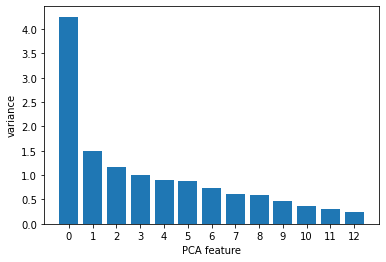

In [56]:
# refer to '15.4.3_3_Unsupervised Learning_Dimension reduction'
# Create a PCA instance: pca
pca = PCA()

# Fit model to numeric features
pca.fit(X_train_mean_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

It looks like PCA features 0 have the most significant variance (first elbow). Will keep PCA features 0 - 3 (2nd elbow) for more variance to be conservative.

In [57]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_train_mean_scaled)

# Transform the numeric features: pca_features
pca_X_train_mean_scaled = pca.transform(X_train_mean_scaled)

# Print the shape of pca_features
print(pca_X_train_mean_scaled.shape)
print(type(pca_X_train_mean_scaled))
pca_X_train_mean_scaled = pd.DataFrame(pca_X_train_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_train_mean_scaled.head()

(5012, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-2.491191,-0.459051,1.182508,0.081856
1,-0.011536,1.268962,-0.139542,0.019501
2,-1.311341,-0.782541,-0.606125,-0.821669
3,0.022627,-0.192157,2.184337,0.431121
4,-0.386141,1.929972,-0.217576,0.681070


In [58]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_test_mean_scaled)

# Transform the numeric features: pca_features
pca_X_test_mean_scaled = pca.transform(X_test_mean_scaled)

# Print the shape of pca_features
print(pca_X_test_mean_scaled.shape)
print(type(pca_X_test_mean_scaled))
pca_X_test_mean_scaled = pd.DataFrame(pca_X_test_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_test_mean_scaled.head()

(1254, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-0.772253,-1.415618,1.773742,-0.246612
1,-0.169652,-1.219467,1.250325,0.200359
2,-2.660008,0.149781,1.212009,-2.183676
3,0.138555,-0.730671,1.873763,-1.039202
4,1.213567,1.276207,1.131137,0.812500


In [59]:
# Combine pca scaled features + dummy variabls + the original binary features
# pca_X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
# print(X_train_odmb.shape)
pca_X_train_mean_scaled_odmb = pd.merge(pca_X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(pca_X_train_mean_scaled_odmb.shape)
pca_X_train_mean_scaled_odmb.head() 

(5012, 229)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-2.491191,-0.459051,1.182508,0.081856,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.011536,1.268962,-0.139542,0.019501,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-1.311341,-0.782541,-0.606125,-0.821669,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0
3,0.022627,-0.192157,2.184337,0.431121,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
4,-0.386141,1.929972,-0.217576,0.681070,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [60]:
# pca_X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
# print(X_test_odmb.shape)
# X_train_odmb.head()
pca_X_test_mean_scaled_odmb = pd.merge(pca_X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(pca_X_test_mean_scaled_odmb.shape)
pca_X_test_mean_scaled_odmb.head() 

(1254, 229)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.772253,-1.415618,1.773742,-0.246612,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.169652,-1.219467,1.250325,0.200359,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,-2.660008,0.149781,1.212009,-2.183676,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.138555,-0.730671,1.873763,-1.039202,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1.213567,1.276207,1.131137,0.812500,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.5 Fit Model 

### 3.5.1 LogisticRegression via sklearn

In [61]:
# make sure the y input for sklearn model is 1d array
y_train.shape, y_test.shape

((5012,), (1254,))

In [62]:
np.logspace(-5, 8, 15)

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

#### 3.5.1.1 numeric features without PCA

In [63]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred0))
print(classification_report(y_test, y_pred0))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8314085687050625
Accuracy on training data: 0.86
Accuracy on test data:     0.82
[[617  97]
 [128 412]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       714
           1       0.81      0.76      0.79       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.82      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 1min 22s


In [64]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1)
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best1 = logreg_cv.best_estimator_
training_accuracy = logreg_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred1 = logreg_best1.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.8, 'penalty': 'elasticnet'}
Best score is 0.8405856283445073
Accuracy on training data: 0.85
Accuracy on test data:     0.83
[[639  75]
 [135 405]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       714
           1       0.84      0.75      0.79       540

    accuracy                           0.83      1254
   macro avg       0.83      0.82      0.83      1254
weighted avg       0.83      0.83      0.83      1254

Wall time: 46min 15s


#### 3.5.1.2 numeric features with PCA

In [65]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best2 = logreg_cv.best_estimator_
training_accuracy = logreg_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred2 = logreg_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8220319082672143
Accuracy on training data: 0.85
Accuracy on test data:     0.81
[[608 106]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       714
           1       0.79      0.75      0.77       540

    accuracy                           0.81      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 1min 27s


In [66]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best3 = logreg_cv.best_estimator_
training_accuracy = logreg_best3.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best3.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred3 = logreg_best3.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8266191445623209
Accuracy on training data: 0.84
Accuracy on test data:     0.81
[[625  89]
 [149 391]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       714
           1       0.81      0.72      0.77       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 46min 14s


### 3.5.2 LogisticRegression via statsmodels

#### 3.5.2.1 numeric features without PCA

Higher the Pseudo R-squ.score, the better the model is. Adding constant may improve the Pseudo R-squ.

In [67]:
# statsmodel w/ constant & penalty term
# Import the statsmodels module
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'
import statsmodels.api as sm

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
X_train_mean_scaled_odmb_c = sm.add_constant(X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
X_test_mean_scaled_odmb_c = sm.add_constant(X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
X_train_mean_scaled_odmb_c_dirty = X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(X_train_mean_scaled_odmb_c.shape[0], X_train_mean_scaled_odmb_c.shape[1])
X_test_mean_scaled_odmb_c_dirty = X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(X_test_mean_scaled_odmb_c.shape[0], X_test_mean_scaled_odmb_c.shape[1])

# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

C:\Users\mkoba\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.30660862350062174
            Iterations: 940
            Function evaluations: 940
            Gradient evaluations: 940


In [68]:
# printing the summary table 
print(log_reg1.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 5012
Model:                          Logit   Df Residuals:                     4773
Method:                           MLE   Df Model:                          238
Date:                Sat, 24 Apr 2021   Pseudo R-squ.:                  0.5507
Time:                        04:09:49   Log-Likelihood:                -1536.7
converged:                       True   LL-Null:                       -3420.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -2.5797      1.393     -1.852      0.064

C:\Users\mkoba\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [69]:
# Predict the labels of the test data: y_pred
y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)

In [70]:
type(y_pred1)

pandas.core.series.Series

In [71]:
y_pred1

0       0.312380
1       0.135140
2       0.962034
3       0.544770
4       0.031120
          ...   
1249    0.744467
1250    0.062816
1251    0.904079
1252    0.439572
1253    0.000000
Length: 1254, dtype: float64

In [72]:
# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred1_df = pd.DataFrame({'probability': y_pred1})
print(y_pred1_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred1_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred1_df.probability] 
#%%%% y_pred1_df.prediction = [list comprehenshion] did not work!
y_pred1_df 

      probability
0        0.312380
1        0.135140
2        0.962034
3        0.544770
4        0.031120
...           ...
1249     0.744467
1250     0.062816
1251     0.904079
1252     0.439572
1253     0.000000

[1254 rows x 1 columns]


,probability,prediction
0,0.312380,0
1,0.135140,0
2,0.962034,1
3,0.544770,1
4,0.031120,0
...,...,...
1249,0.744467,1
1250,0.062816,0
1251,0.904079,1
1252,0.439572,0


In [73]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1_df.prediction))
print(classification_report(y_test, y_pred1_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

[[616  98]
 [131 409]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       714
           1       0.81      0.76      0.78       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.81      1254
weighted avg       0.82      0.82      0.82      1254



Overall scores are little lower than sklearn model but runs much faster (10-20min?)

#### 3.5.2.2 numeric features with PCA

In [74]:
# statsmodel w/ constant & penalty term
# Import the statsmodels module
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'
import statsmodels.api as sm

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
pca_X_train_mean_scaled_odmb_c = sm.add_constant(pca_X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
pca_X_test_mean_scaled_odmb_c = sm.add_constant(pca_X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
pca_X_train_mean_scaled_odmb_c_dirty = pca_X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_train_mean_scaled_odmb_c.shape[0], pca_X_train_mean_scaled_odmb_c.shape[1])
pca_X_test_mean_scaled_odmb_c_dirty = pca_X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_test_mean_scaled_odmb_c.shape[0], pca_X_test_mean_scaled_odmb_c.shape[1])

# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg2 = sm.Logit(y_train, pca_X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.32451024040086723
            Iterations: 583
            Function evaluations: 583
            Gradient evaluations: 583


In [75]:
# printing the summary table 
print(log_reg2.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 5012
Model:                          Logit   Df Residuals:                     4782
Method:                           MLE   Df Model:                          229
Date:                Sat, 24 Apr 2021   Pseudo R-squ.:                  0.5245
Time:                        04:11:00   Log-Likelihood:                -1626.4
converged:                       True   LL-Null:                       -3420.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -2.4594      1.322     -1.860      0.063

In [76]:
# Predict the labels of the test data: y_pred
y_pred2 = log_reg2.predict(pca_X_test_mean_scaled_odmb_c_dirty)

In [77]:
type(y_pred2)

pandas.core.series.Series

In [78]:
# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred2_df = pd.DataFrame({'probability': y_pred2})
print(y_pred2_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred2_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred2_df.probability] 
#%%%% y_pred2_df.prediction = [list comprehenshion] did not work!
y_pred2_df 

       probability
0     4.342312e-01
1     5.508351e-02
2     9.751229e-01
3     9.014203e-01
4     1.148795e-01
...            ...
1249  7.938715e-01
1250  2.900837e-01
1251  8.797908e-01
1252  6.778414e-01
1253  5.613259e-08

[1254 rows x 1 columns]


,probability,prediction
0,4.342312e-01,0
1,5.508351e-02,0
2,9.751229e-01,1
3,9.014203e-01,1
4,1.148795e-01,0
...,...,...
1249,7.938715e-01,1
1250,2.900837e-01,0
1251,8.797908e-01,1
1252,6.778414e-01,1


In [79]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2_df.prediction))
print(classification_report(y_test, y_pred2_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

[[607 107]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       714
           1       0.79      0.75      0.77       540

    accuracy                           0.81      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.80      0.81      0.80      1254



with PCA restulted in slightly better scores overall than without PCA. 

### 3.5.3 Random Forest via sklearn

#### 3.5.3.1 numeric features without PCA

In [80]:
%%time
# refer to '14.3.5_Case Study - Decision Trees - RR Diner Coffee'
from sklearn.ensemble import RandomForestClassifier

# Optimize max_depth=n (3-10?) %%%% which parameter to optimize? n_estimators? (100-300) using GridSearch?
# Plug in appropriate max_depth and random_state parameters 
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'
rfc = RandomForestClassifier(criterion='gini', max_depth=3, random_state = 1234) #%%%%% from previous best model!??

# Model and fit
rfc.fit(X_train_mean_scaled_odmb, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = rfc.predict(X_test_mean_scaled_odmb)

# compute accuracy of train set and test set
training_accuracy = rfc.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training data: 0.80
Accuracy on test data:     0.77
[[639  75]
 [216 324]]
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       714
           1       0.81      0.60      0.69       540

    accuracy                           0.77      1254
   macro avg       0.78      0.75      0.75      1254
weighted avg       0.78      0.77      0.76      1254

Wall time: 428 ms


In [81]:
%%time
# start with small number of trees (n_estimators = [ 50, 100, 150, 200])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(50,250,50) # array([ 50, 100, 150, 200])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Best score is 0.828813957329608
Accuracy on training data: 0.85
Accuracy on test data:     0.80
[[620  94]
 [151 389]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       714
           1       0.81      0.72      0.76       540

    accuracy                           0.80      1254
   macro avg       0.80      0.79      0.80      1254
weighted avg       0.80      0.80      0.80      1254

Wall time: 4min 51s


Efficient model: running time within 10min! since 200 trees was the best, will increase the tree number.

In [82]:
%%time
# Increase the number of trees (n_estimators = [200, 300, 400, 500])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(200,600,100) # array([200, 300, 400, 500])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best score is 0.8306097675038757
Accuracy on training data: 0.85
Accuracy on test data:     0.81
[[625  89]
 [154 386]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       714
           1       0.81      0.71      0.76       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.80      1254

Wall time: 13min 8s


Since 500 trees was the best, will increase the tree number.

In [83]:
%%time
# Increase the number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best1 = rfc_cv.best_estimator_
training_accuracy = rfc_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
rfc_y_pred1 = rfc_best1.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred1))
print(classification_report(y_test, rfc_y_pred1))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 600}
Best score is 0.8308085722871306
Accuracy on training data: 0.85
Accuracy on test data:     0.81
[[626  88]
 [154 386]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       714
           1       0.81      0.71      0.76       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.80      1254

Wall time: 41min 48s


600 trees got very slight score improvement from 500 trees.

#### 3.5.3.1 numeric features with PCA

In [84]:
%%time
# Start with the large number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best2 = rfc_cv.best_estimator_
training_accuracy = rfc_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
rfc_y_pred2 = rfc_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred2))
print(classification_report(y_test, rfc_y_pred2))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 600}
Best score is 0.8000827855754095
Accuracy on training data: 0.81
Accuracy on test data:     0.79
[[676  38]
 [224 316]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       714
           1       0.89      0.59      0.71       540

    accuracy                           0.79      1254
   macro avg       0.82      0.77      0.77      1254
weighted avg       0.81      0.79      0.78      1254

Wall time: 42min 19s


numeric features with PCA gave noticeably lower overall scores than numeric features without PCA. Since running time is about the same, will use numeric features without PCA for further analysis.

## 3.6 Feature importance analysis

### 3.6.1 LogisticRegression via sklearn using shap

In [85]:
# refer to 'https://github.com/slundberg/shap'
# install shap
# conda install -c conda-forge shap # this this code in Anaconda prompt(anaconda3)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


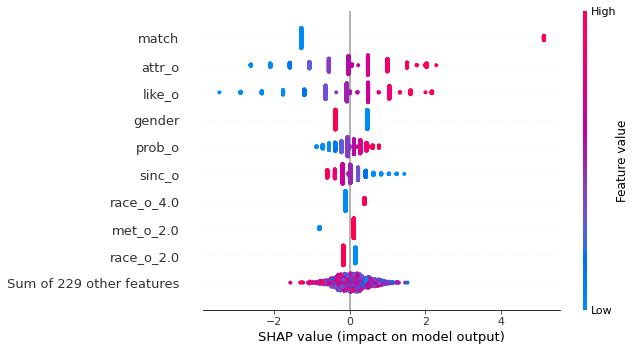

Wall time: 1.1 s


In [86]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.ipynb'
# import shap
import shap
shap.initjs() #%%%%% what is this for?

# Explain the linear model
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns)
logreg_shap_values1 = logreg_explainer1(X_test_mean_scaled_odmb)

# Summarize the effect of all the features
shap.plots.beeswarm(logreg_shap_values1)

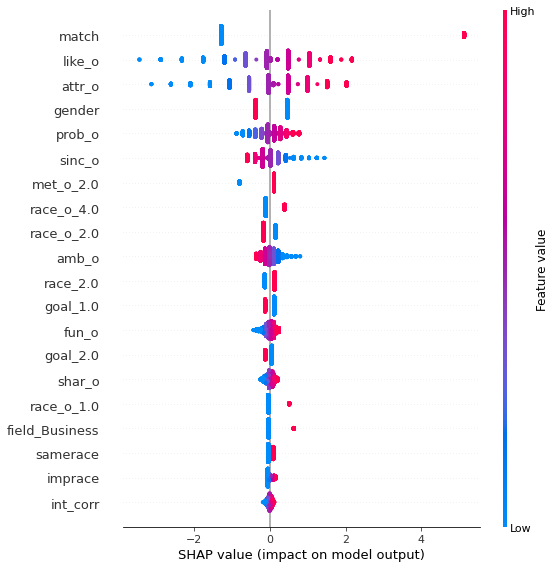

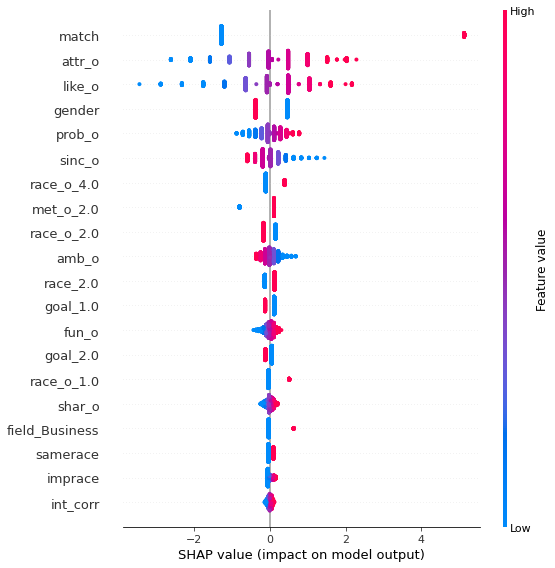

Wall time: 2.16 s


In [87]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values2 = logreg_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values2, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values3 = logreg_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values3, X_test_mean_scaled_odmb)

**shap plot interpretation**
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

Refererence: 'https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a'

sklearn logistic regression model (both genders):
- top 20 important features are the same between train set and test set with slight difference in order
- positive correlation: match, like_o, attr_o, prob_o, met_o_2.0, race_o_4.0, race_2.0, fun_o, shar_o, race_o_1.0, fild_Business, samerace, imprace, int_corr
    - like_o, attr_o, fun_o, shar_o, prob_o: the higher the partner rate the subject in how much they like the subject, how much they think the subject like them, attractiveness, shared interest, and fun, the pertner will want to date the subject. 
    -  int_corr: the partner tend to want to date the subject with higher the correlation between subject’s and partner’s ratings of interests.
    - met_o_2.0: the pertner tend to want to date the subject whom they have never met.
    - race_o_4.0: Asian/Pacific Islander/Asian-American partner tend give more yes decision to date the subject.
    - race_2.0: European/Caucasian-American subject is popular and likely to get more yes decision to date from a partner.
    - race_o_1.0: Black/African American partner tend give more yes decision to date the subject.
    - fild_Business: peopole majoring Business is popular and likely to get more yes decision to date from a partner.
    - samerace: partner tend give more yes decision to date the subject with same race.
    - imprace: the partner who cares more about dating a subject with the same race tend to give more yes decision to date the subject.
- negarive correlation: gender, sinc_o, rece_o_2.0, amb_o, goal_1.0, goal_2.0.
    - gender: subject gender (0=female, 1=male) of opposite of the partner gender, meaning female partner tend to 

### 3.6.2 LogisticRegression via statsmodel

In [88]:
# use statsmodels.discrete.discrete_model.LogitResults.get_margeff!?

### 3.6.3 Random Forest via sklearn

#### 3.6.3.1 Using shap

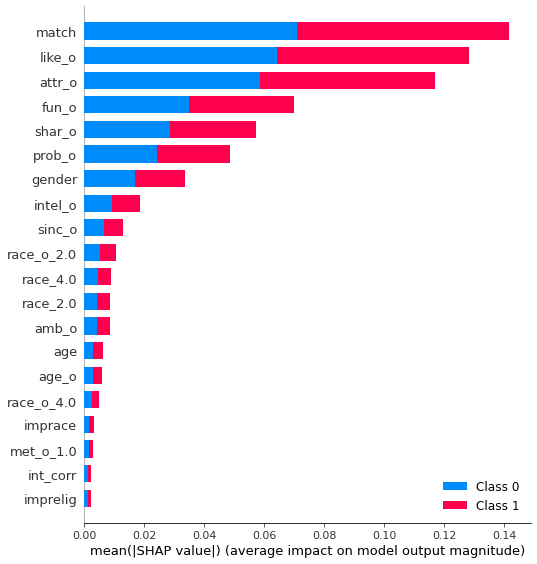

Wall time: 58.7 s


In [89]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.ipynb'
import shap

shap.initjs() #%%%%% what is this for?

# Explain the linear model
rfc_explainer1 = shap.TreeExplainer(rfc_best1, feature_names=X_train_mean_scaled_odmb.columns)
rfc_shap_values1 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb) # this shap value is 'list' object with no

# Summarize the effect of all the features
shap.summary_plot(rfc_shap_values1, X_test_mean_scaled_odmb)

In [90]:
# check size of rfc_y_pred1
rfc_y_pred1 # need to convert this to list with 2 element.

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [91]:
# to count the 0 and 1 in y_pred1_rfc
# refer to 'https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray'
import collections
collections.Counter(rfc_y_pred1)

Counter({0: 780, 1: 474})

In [92]:
# ideally this value should be 0 to make symmetry plot above!?
print(np.abs([np.sum(list(rfc_shap_values1[0])), np.sum(list(rfc_shap_values1[1]))] + rfc_explainer1.expected_value - [780, 474]).max()) 
#%%%% original code was rcf_shap_values.sum(1), but rcf_shap_values is list object that does not have sum attribute.
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max() > this output should be 0 to get symmetry plot.

778.0365410499593


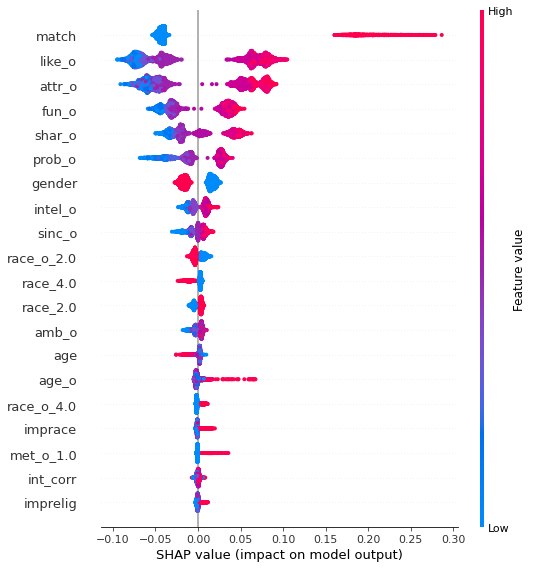

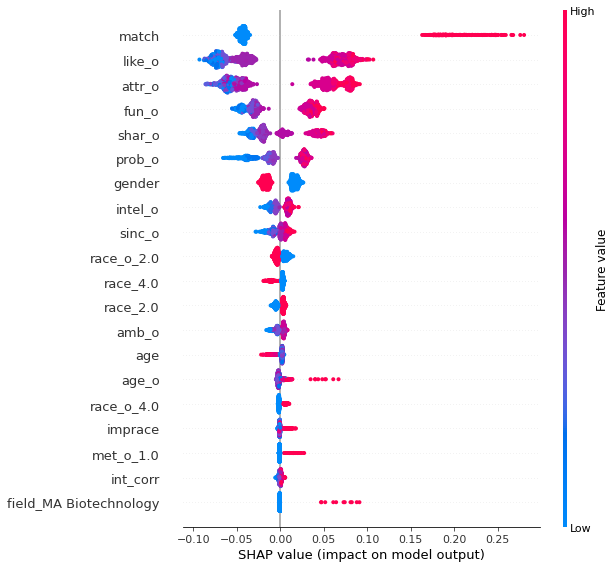

Wall time: 1min 14s


In [93]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values2[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3 = rfc_explainer1.shap_values(X_test_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values3[1], X_test_mean_scaled_odmb)

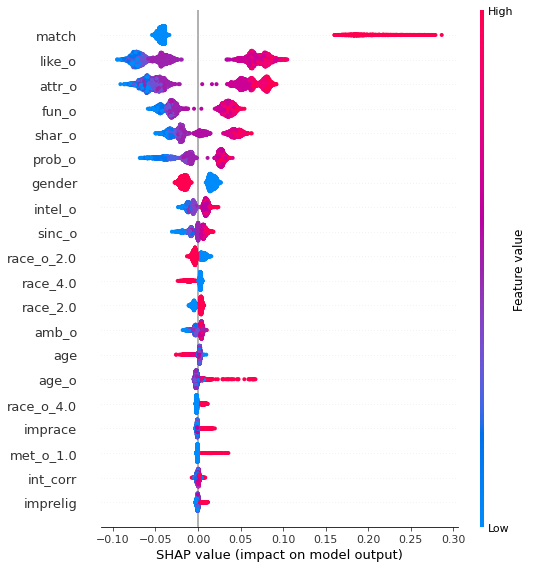

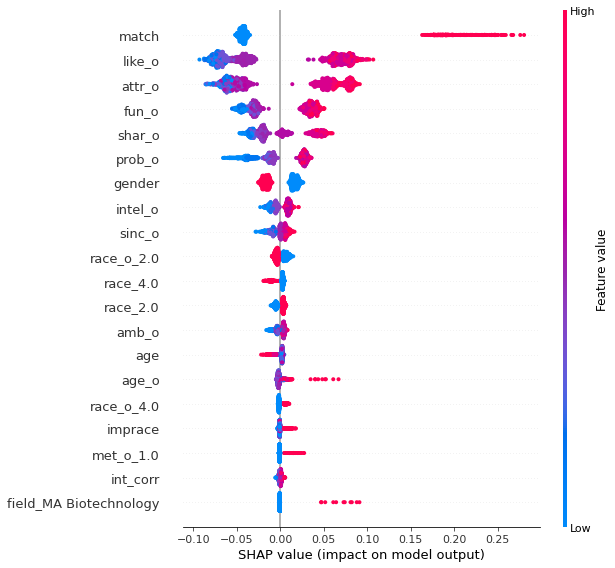

Wall time: 1min 14s


In [94]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2a = rfc_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values2a[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3a = rfc_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values3a[1], X_test_mean_scaled_odmb)

#### 3.6.3.2 Using Sklearn Tree model attribute: feature_importances_ 

30


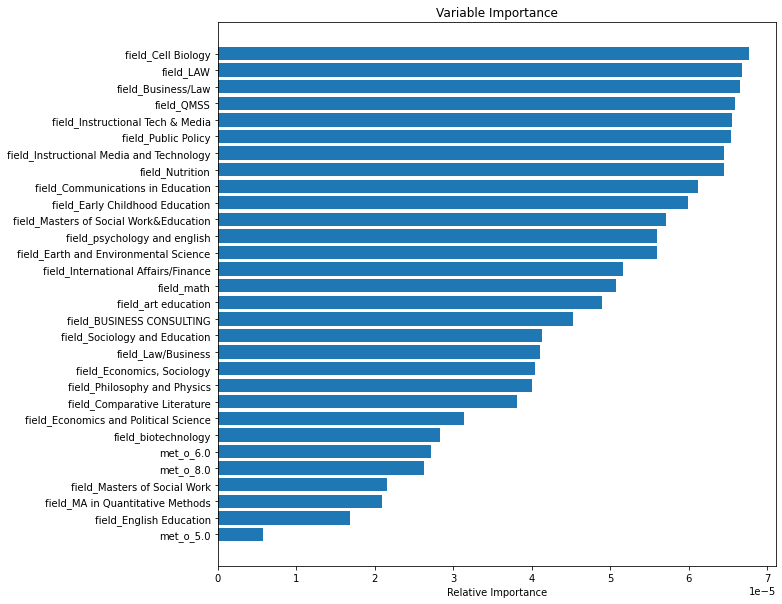

In [95]:
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[:30]
sorted_idx = np.argsort(feature_importance_rfc)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


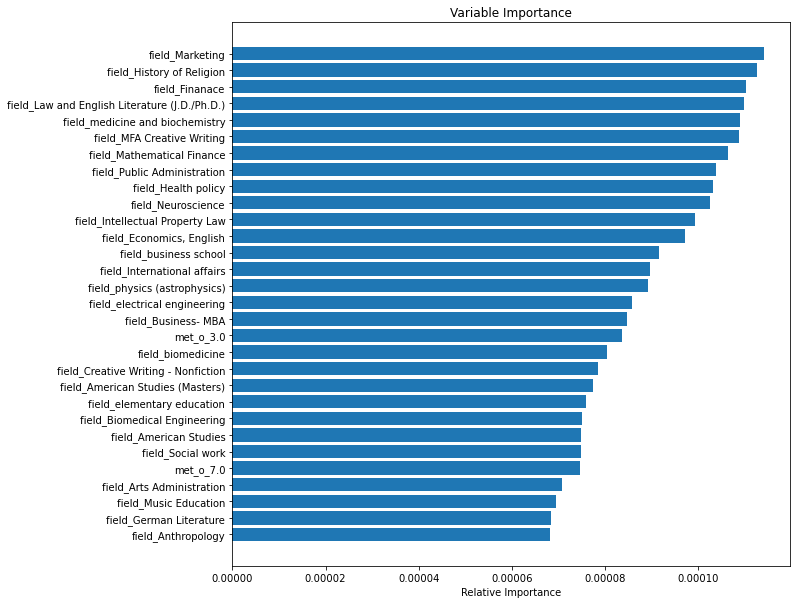

In [96]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[30:60]
sorted_idx = np.argsort(feature_importance_rfc)[30:60]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


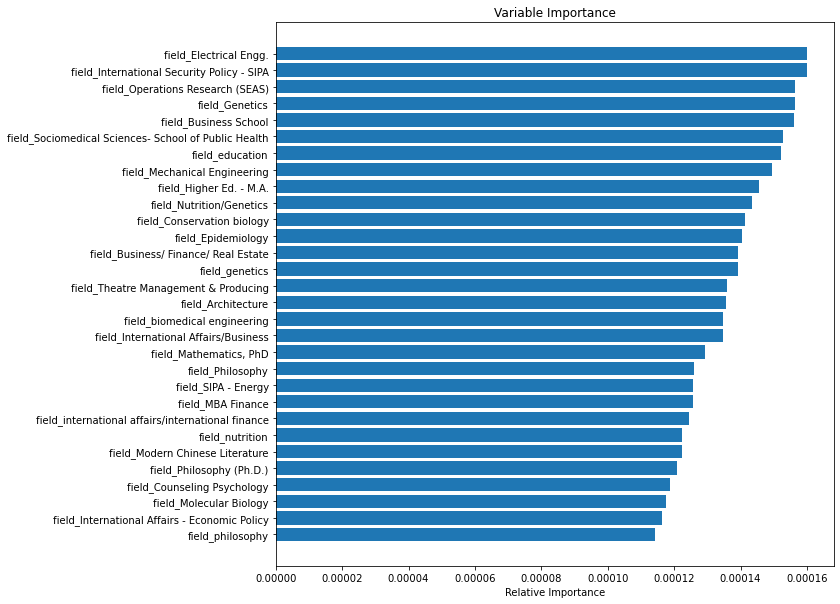

In [97]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[60:90]
sorted_idx = np.argsort(feature_importance_rfc)[60:90]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


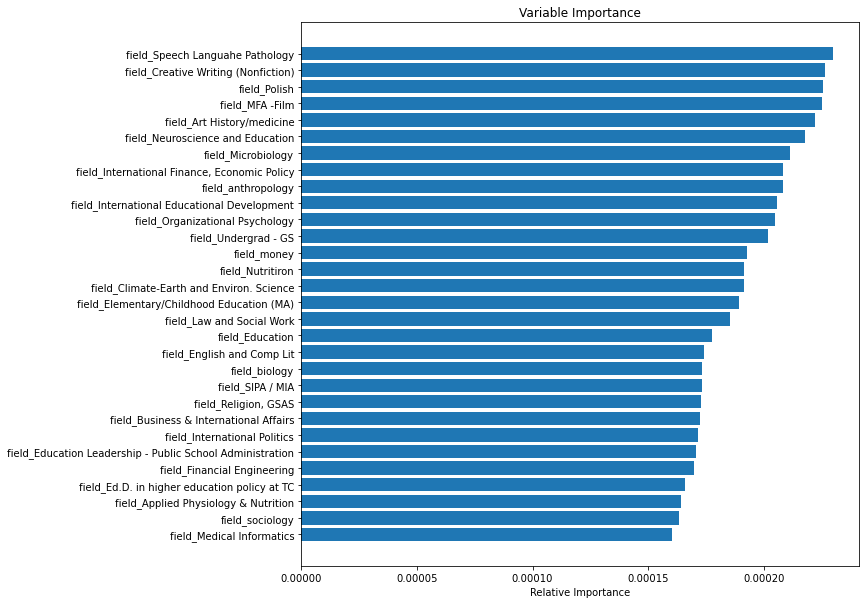

In [98]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[90:120]
sorted_idx = np.argsort(feature_importance_rfc)[90:120]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


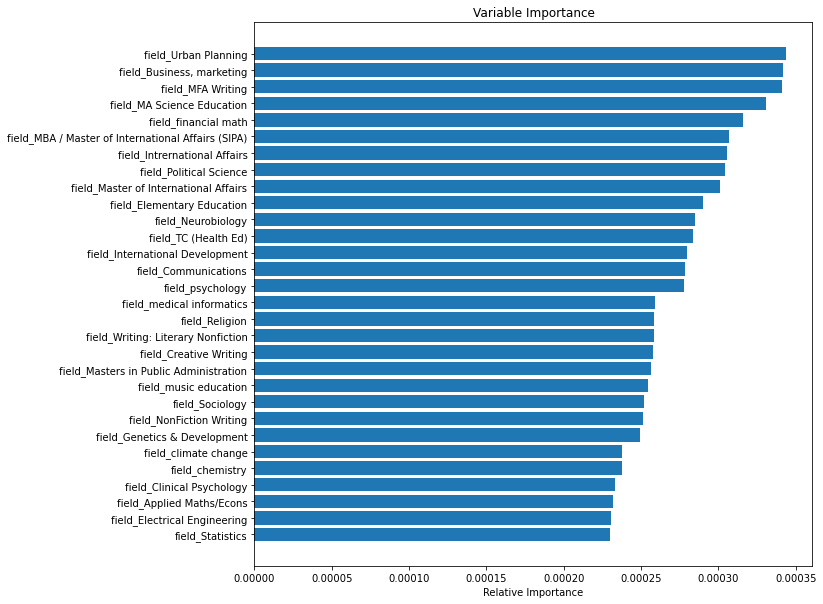

In [99]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[120:150]
sorted_idx = np.argsort(feature_importance_rfc)[120:150]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


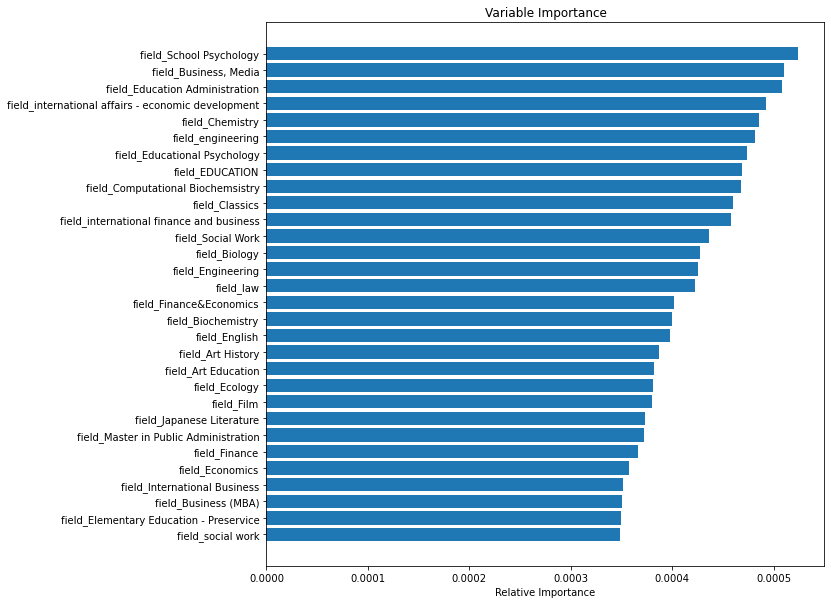

In [100]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[150:180]
sorted_idx = np.argsort(feature_importance_rfc)[150:180]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


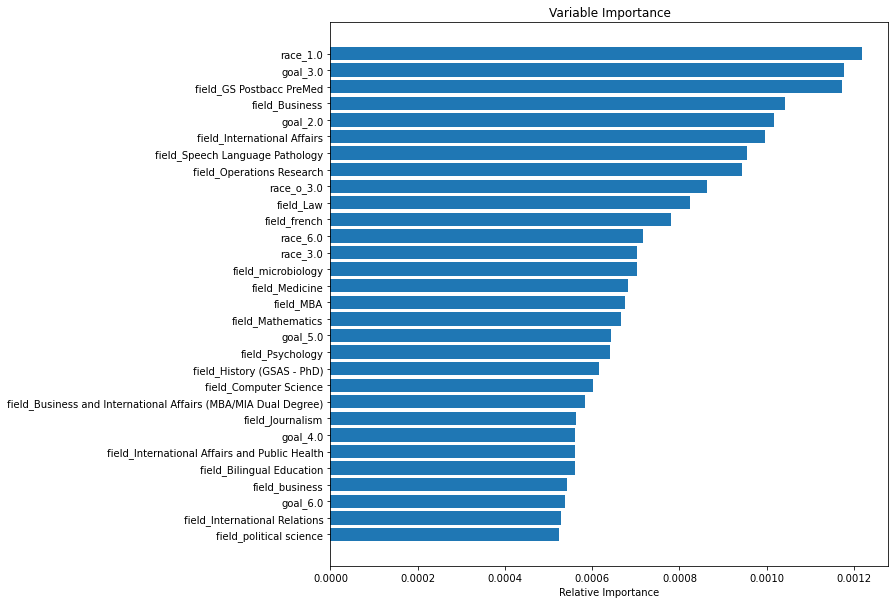

In [101]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[180:210]
sorted_idx = np.argsort(feature_importance_rfc)[180:210]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

28


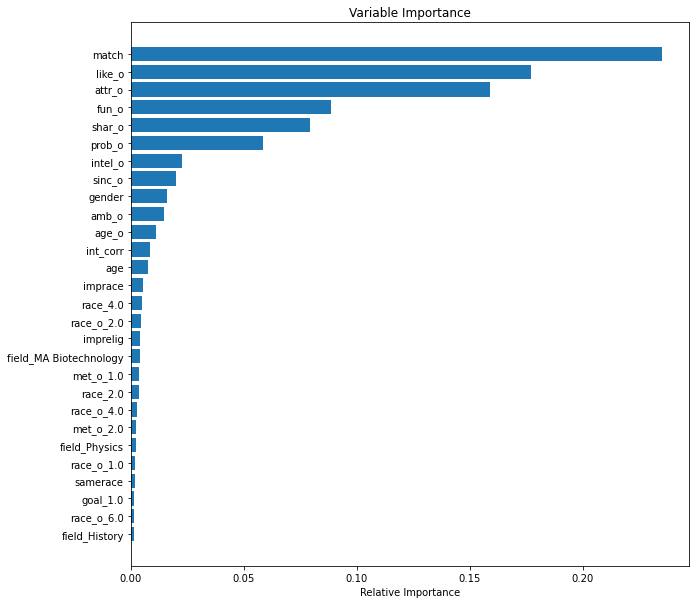

In [102]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[210:240]
sorted_idx = np.argsort(feature_importance_rfc)[210:240]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [103]:
# refer to 'https://ff06-2020.fastforwardlabs.com/'
# to interpret resutls. 

## 3.7 Conclusion
Most powerful model in terms of model evaluation metrics, computational complexity, scalability, and maintenance costs is
- TBD

### reference
- sklearn codes:
    - '14.1.2_3_Supervised Learning_Tuning': logisticRegression, confusion_matrix, classification_report, 
    - '14.1.2_4_Supervised Learning with scikit-learn_Preprocessing and Pipeline': buiding pipeline, scaler, get_dummies() 
    - '6_GuidedCapstone/04_preprocessing_and_training_mk': scaler, Random Forest model
     - '14.2.11_Case Study - Logistic Regression/Logistic Regression Advanced Case Study_mk': plot logisticRegression output.
- Statsmodel codes:
    - '11.4.1_Case Study - Linear Regression/Regression Case Study - the Red Wine Dataset - Tier 3_mk': sm.OLS(y, X), plot predictions (y_test vs. y_pred)
- Random Forest model codes:'14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.3.5_Case Study - Decision Trees - RR Diner Coffee/Decision Tree Specialty Coffee Case Study - Tier 3_mk'
    
- refer to 'https://pandas.pydata.org/pandas-docs/version/0.24.0rc1/api/generated/pandas.Series.to_numpy.html'
    - series to numpy: s.to_numpy()
- data preprocessing: 
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk': get_dummies(), sklearn scaler
    - '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk': exctract categorical data
    - '15.4.3_3_Unsupervised Learning_Dimension reduction': PCA
- feature importance interpretation: SHAP
    - https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9
    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    - https://ff06-2020.fastforwardlabs.com/
   

### Questions:
- how do perform cross validation on statsmodel?
    - Answers:
    - currently not avaliable(can't perform cross validation using statsmodels.api yet) and is not compatibible with sklearn cross_val_score or GredSearchCV...etc
    - need to write custom codes if you really want to
    - people usually use sklearn for building ML model.
    - statsmodel is used for quick stats calculation from a model than model optimazation. 
- how to use ElasticNet in sklearn LogisticRegression? (currently only l1 or l2 are available!?)
    - Answers:
    - need to change the default solver (lbfgs) to saga in order to use elasticnet
        - param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 
        - logreg = LogisticRegression(solver='saga', max_iter=10000) 
        - logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
- how to compare the performance of statsmodel and sklearn lotistic model
    - Answers:
    - use sklearn confusion_matrix, classification_report on the y_pred, y_test
    - need to convert the statsmodel's y_pred in probability to binary system (0,1) in advance
    
- how to choose scoring system for GridSearhCV like we can do for cross_val_score? (what is the defaut score?, accuracy?)
    - cv_accuracy = cross_val_score(clf, Xlr, ylr, cv=5, scoring='accuracy')
    - cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
    - Answers:
    - use GridSearhCV(logreg, param_grid, scoring = 'roc_auc', cv=5), default scoring = 'accuracy'
    - should not use 'accuracy' scoring for data with imbalanced disribution.
    - for logistic regression, target variable (0,1), if there is much more (more than 10x!?) 1 than 0 (or vice verso) > imbalanced data
- for logistic regression model, do I need to leave all the binary variable (or only dependent variable) out for scaling.
    - Answers: 
    - leaving it out all the binary viarable for scaling for logistic regression model might be better!?
    - 